In [1]:
import pandas as pd
import numpy as np
from pyDeepInsight import ImageTransformer
from pyDeepInsight.feature_selection import CAMFeatureSelector
import torch
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader,Dataset, Subset
from sklearn.model_selection import StratifiedKFold, train_test_split
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from torchscripts.torch_train import *
from torchscripts.classifiers import *
import random
import warnings
from math import ceil, sqrt
from collections import Counter
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA
import umap.umap_ as umap
import pickle 
warnings.simplefilter('ignore')
CUDA_LAUNCH_BLOCKING=1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def save_picke(obj, img_size):
    fname = "image_transformer"+str(img_size)
    with open(fname, 'wb') as f:
        pickle.dump(obj, f)
#save_picke(it2,100)
def load_pickle(fname):
    with open(fname, 'rb') as f:
        obj = pickle.load(f)
    return obj

preprocess = transforms.Compose([
    transforms.ToTensor()
])

c:\Users\dmech\anaconda3\envs\torch\lib\site-packages\umap\distances.py:1053: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\dmech\anaconda3\envs\torch\lib\site-packages\umap\distances.py:1061: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\dmech\anaconda3\envs\torch\lib\site-packages\umap\distances.py:1076: NumbaDepreca

cuda


c:\Users\dmech\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:646: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


In [2]:
import modin.pandas as mpd
from scipy.linalg import inv
import re
data = pd.read_csv('./data/outer/species_alldsets_asin0.csv', index_col=0 )
le = LabelEncoder()
y= le.fit_transform(data['y'])
y = y.reshape(-1) 


In [4]:
metabs = pd.read_csv('final_metabolites2.csv', index_col=0)
transposed_df = metabs.T
transposed_df.rename(columns=lambda x: re.sub(r'\W+', '', x), inplace=True)
common_cols = set(transposed_df.columns) & set(species_values)
current_df = transposed_df[list(common_cols)]
column_sums = current_df.sum(axis=0)
filtered_sums = column_sums.loc[column_sums != 0]

In [7]:
X = data.drop('y', axis=1)
cols = X.columns.tolist()

# Shuffle the column names
random.shuffle(cols)

# Reorder the DataFrame with shuffled columns
X = X[cols]
#XX = X.reset_index(drop=True)
current_df = transposed_df[list(common_cols)]
missing_cols = set(X.columns) - set(current_df.columns) 
for col in missing_cols:
    current_df[col] = 0

# reordercol for concat
current_df= current_df[X.columns]
combined_df = pd.concat([current_df,X])


In [17]:
data = pd.read_csv('./data/outer/species_asin0.csv', index_col=0 )
data.index = data.index.str.replace('^X', '', regex=True)
img_data= pd.read_csv('./data/outer/species_alldsets_asin0.csv', index_col=0 )
#img_data['y'] = img_data['y'].str.extract('(\d)').astype(int)
y_img= le.fit_transform(img_data['y'])
y_img_np = y_img.reshape(-1) 

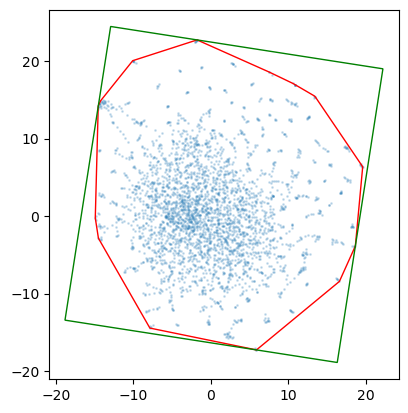

In [19]:
X_img = img_data.drop('y', axis=1)
metabs = pd.read_csv('metabolite_results.csv', index_col=0)
transposed_df = metabs.T
transposed_df.rename(columns=lambda x: re.sub(r'\W+', '', x), inplace=True)
common_cols = set(transposed_df.columns) & set(species_values)
current_df = transposed_df[list(common_cols)]
missing_cols = set(X_img.columns) - set(current_df.columns) 
for col in missing_cols:
    current_df[col] = 0

# reordercol for concat
X_img = X_img.sample(axis=1, frac=1)
current_df= current_df[X_img.columns]
combined_df = pd.concat([current_df,X_img ])
isize=180
reducer_tsne = TSNE(n_components=2,metric="cosine", n_jobs=32,perplexity = 150 ,early_exaggeration=24, learning_rate=200)
reducer_umap= umap.UMAP(n_components=2,metric='cosine',n_jobs=32, n_neighbors=3 , min_dist=0.9, random_state=21)
it = ImageTransformer(pixels=(isize,isize), feature_extractor= reducer_umap )
it.fit(combined_df, y=y_img_np, plot=True)
X_img_transformed= it.transform(X_img)[:, :, :, 0]

In [22]:
# plt.figure(figsize=(10, 7.5))
# fdm = it.feature_density_matrix()

# # # Flatten your data and remove any NaN values
# fdm_flat = fdm.flatten()
# # fdm_flat = fdm_flat[~np.isnan(fdm_flat)]

# # Plot histogram
# plt.hist(fdm_flat ,bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)

# plt.title('Histogram of FDM Values')
# plt.xlabel('Value')
# plt.ylabel('Frequency')

# plt.grid(axis='y', alpha=0.75)
# plt.show()

In [23]:
resblocks_params = [[16, 3, 1], [32, 3, 2]]
X_full_img_tensor = torch.stack([preprocess(img) for img in X_img_transformed]).to(device).float()
X = X_full_img_tensor
y_img_tensor = torch.tensor(y_img)
test_dataset2 = TensorDataset(X_full_img_tensor, y_img_tensor)
train_dataloader_tab = DataLoader(test_dataset2, batch_size=32, shuffle=True)

In [25]:
criterion = nn.CrossEntropyLoss()
fname = "best_model_" + "deeplast" + ".pth"
mod = ResClass(isize, resblocks_params)
mod.to(device)
opt3 =   optim.Adam(mod.parameters(),  lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001)
results = train_best_image(mod,  device, criterion, opt3, train_dataloader_tab , train_dataloader_tab,75,50,fname)
model1 = ResClass(isize, resblocks_params)
model1.load_state_dict(torch.load(fname))

Saving the best model (Epoch: 1, Validation Accuracy: 0.4080)...
Saving the best model (Epoch: 2, Validation Accuracy: 0.6683)...
Saving the best model (Epoch: 3, Validation Accuracy: 0.7271)...
Saving the best model (Epoch: 4, Validation Accuracy: 0.7895)...
Saving the best model (Epoch: 6, Validation Accuracy: 0.8374)...
Saving the best model (Epoch: 7, Validation Accuracy: 0.8439)...
Saving the best model (Epoch: 8, Validation Accuracy: 0.8758)...
Saving the best model (Epoch: 9, Validation Accuracy: 0.8801)...
Saving the best model (Epoch: 10, Validation Accuracy: 0.8923)...
Saving the best model (Epoch: 11, Validation Accuracy: 0.8993)...
Saving the best model (Epoch: 12, Validation Accuracy: 0.9085)...
Saving the best model (Epoch: 13, Validation Accuracy: 0.9159)...
Saving the best model (Epoch: 14, Validation Accuracy: 0.9285)...
Saving the best model (Epoch: 15, Validation Accuracy: 0.9294)...
Saving the best model (Epoch: 16, Validation Accuracy: 0.9350)...
Saving the best mo

<All keys matched successfully>

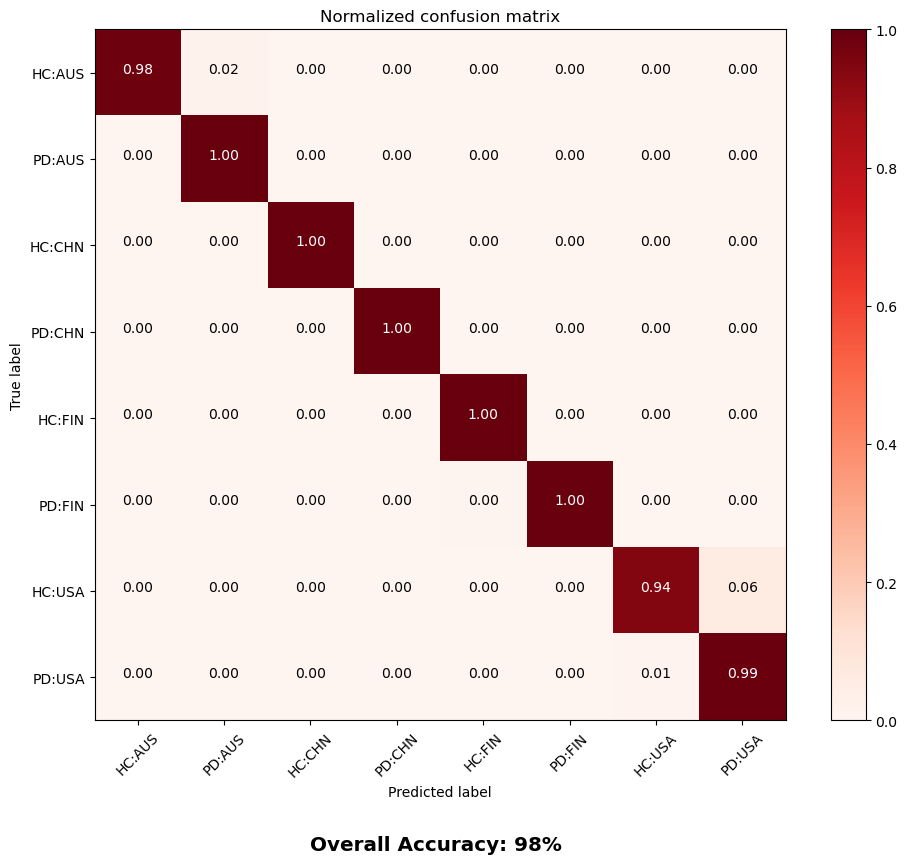

In [26]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

model1.eval()
model1.cuda()

# create lists to hold the true labels and predicted labels
true_labels = []
pred_labels = []
n_classes = 8
classes = ['HC:AUS','PD:AUS', 'HC:CHN', 'PD:CHN', 'HC:FIN','PD:FIN', 'HC:USA','PD:USA']
# loop through the validation dataloader and make predictions on each batch

for data, labels in train_dataloader_tab:
    # move the inputs and labels to the device (e.g. GPU) if available
    data, labels = data, labels.to(device, dtype=torch.long)

    # make predictions using the model
    outputs= model1(data)
    _, predicted = torch.max(outputs, 1)

    # add the true and predicted labels to their respective lists
    true_labels.extend(labels.cpu().numpy())
    pred_labels.extend(predicted .cpu().numpy())
cm = confusion_matrix(true_labels, pred_labels,labels=[0,4,1,5,2,6,3,7])
overall_acc = accuracy_score(true_labels, pred_labels)*100
# calculate the confusion matrix
pred_labels = le.inverse_transform(pred_labels)
true_labels = le.inverse_transform(true_labels)
#pred_labels = np.array(pred_labels,dtype=str)
#cm = confusion_matrix(true_labels, pred_labels)
#classes = np.unique(pred_labels)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot confusion matrix
plt.figure(figsize=(10,8))
plot_confusion_matrix(cm, classes=classes, normalize=True, title='Normalized confusion matrix')
plt.text(2,9, f'Overall Accuracy: {overall_acc:.0f}%',weight="bold",size="x-large")
#plt.savefig('cohort_cm.png', bbox_inches='tight')
plt.show()

In [27]:
from typing import Union, Optional, Dict
#from .image_transformer import ImageTransformer

import numpy as np
from torch import nn, Tensor
from torch.utils.data import TensorDataset, DataLoader

import pytorch_grad_cam
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchcam.methods._utils import locate_candidate_layer

class CAMFeatureSelector:
    """Extract important features from a model using class activation mapping
    (CAM).
    This class takes a trained model and it's training data to identify
    important features to prediction of each class.
    """

    def __init__(self, model: nn.Module,
                 it: ImageTransformer,
                 target_layer: Union[str, nn.Module] = None,
                 cam_method: str = "GradCAM") -> None:
        """Generate a CAMFeatureSelector instance
        Args:
            model: trained pytorch.nn.Module CNN model
            it: ImageTransformer class used to create the images that trained
                the model
            target_layer: the target layer of the model, the name of the
                target layer, or "None" for the layer to be selected
                automatically
            cam_method: name of the CAM method from pytorch-grad-cam
        """

        if cam_method not in CAM_FUNCTIONS.keys():
            raise ValueError(
                f"Unknown cam_method {cam_method}. Valid methods are "
                f"{CAM_FUNCTIONS.keys()}"
            )
        self.cam_method = cam_method
        self.feature_coords = it.coords()
        self.model = model
        self.target_layer = self._resolve_target_layer(target_layer)

    def _resolve_target_layer(self,
                              target_layer: Union[str, nn.Module] = None
                              ) -> Optional[nn.Module]:
        """Convert layer name to layer or identify candidate layer if none
        given.
        Args:
            target_layer: the target layer of the model, the name of the
                target layer, or "None" for the layer to be selected
                automatically
        """
        resolved_target = None
        submodule_dict = dict(self.model.named_modules())
        if isinstance(target_layer, nn.Module):
            resolved_target = target_layer
        elif isinstance(target_layer, str):
            if target_layer not in submodule_dict.keys():
                raise ValueError(
                    f"Unable to find submodule {target_layer} in the model")
            else:
                resolved_target = submodule_dict[target_layer]
        elif target_layer is None:
            target_layer = locate_candidate_layer(self.model)
            resolved_target = submodule_dict[target_layer]

        return resolved_target

    def compute_cam(self, X: Tensor, y: Tensor,
                    batch_size: int = 1, use_cuda: bool = False,
                    ) -> np.ndarray:
        """Compute class activation map (CAM) for each image in X of classes y.
        Args:
            X: Tensor of input images
            y: Tensor of input labels
            batch_size: Batch size (default 1)
            use_cuda: Whether to use cuda for calculating CAMs
        Return:
            A numpy array of CAMs
        """
        activations = np.empty((0, X.shape[-2], X.shape[-1]))
        ds = TensorDataset(X, y)
        dl = DataLoader(ds, batch_size=batch_size, shuffle=False)

        func = CAM_FUNCTIONS[self.cam_method]
        self.model.eval()
        for i, data in enumerate(dl):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            cam = func(model=self.model, target_layers=[self.target_layer],
                       use_cuda=use_cuda)
            targets = [ClassifierOutputTarget(label) for label in labels]
            grayscale_cam = cam(input_tensor=inputs, targets=targets)
            activations = np.append(activations, grayscale_cam, axis=0)

        return activations

    @staticmethod
    def flatten_cam(cams: np.ndarray,
                    method: str = "mean") -> np.ndarray:
        """Flatten multiple CAMs into a single CAM.
        Args:
            cams: ndarray of CAMs
            method: Method to flatten CAMs. When used with feature selection
                threshold, max is essentially a union operation, and min is an
                intersect operation.
        Returns:
            A numpy array
        """
        if method == "mean":
            flat_cam = np.mean(cams, axis=0)
        elif method == "max":
            flat_cam = np.max(cams, axis=0)
        elif method == "min":
            flat_cam = np.min(cams, axis=0)
        else:
            raise ValueError(f"Unknown CAM flatten method {method}")
        return flat_cam

    @staticmethod
    def flatten_classes(labels: np.ndarray, cam: np.ndarray,
                        method: str = "mean") -> Dict[int, np.ndarray]:
        """Flatten CAMs across all classes
        Args:
            labels: class labels for cam array
            cam: ndarray of CAMs
            method: method to merge CAMs per class passed to .flatten_cam()
        Returns:
             A dictionary with class labels as keys and a single CAM as
             the value
        """
        cats = np.unique(labels)
        cat_cam = {}
        for cat in cats:
            cat_act = cam[np.where(labels == cat)[0], :, :]
            flat_act = CAMFeatureSelector.flatten_cam(
                cams=cat_act, method=method)
            cat_cam[cat] = flat_act
        return cat_cam

    def calculate_class_activations(self, X: Tensor, y: Tensor,
                                    batch_size: int = 1, flatten_method="mean"
                                    ) -> Dict[int, np.ndarray]:
        """Calculate CAM for each input then flatten for each class.
        Args:
            X: Tensor of input images
            y: Tensor of input labels
            batch_size: Batch size (default 1)
            flatten_method: Method to flatten CAMs for each class. 'max' is
                essentially a union operation, and 'min' is an
                intersect operation.
        Returns:
            A dictionary with classes as keys and the flattened CAM as values
        """
        use_cuda = X.is_cuda
        activations = self.compute_cam(X=X, y=y, batch_size=batch_size, use_cuda=use_cuda)
        y_cpu = y.detach().cpu().numpy()
        cat_cam = self.flatten_classes(y_cpu, activations, method=flatten_method)

        return cat_cam

    def select_class_features(self, cams: Dict[int, np.ndarray],
                              threshold: float = 0.6) -> Dict[int, np.ndarray]:
        """Select features for each class using class-specific CAMs. Input
        feature coordinates are filtered based on activation at same
        coordinates.
        Args:
            cams: A dictionary with classes as keys and a CAM as values
            threshold: Activation cutoff for feature importance
        Returns:
            A dictionary with classes as keys and an array of feature indices
            as values
        """
        class_idx = {}
        for cat, cam in cams.items():
            cam_pass = np.stack(np.where(cam >= threshold)).T
            it_pass = np.where(
                (self.feature_coords == cam_pass[:, None]).all(-1).any(-1)
            )[0]
            class_idx[cat] = it_pass
        return class_idx


CAM_FUNCTIONS = {
    "GradCAM": pytorch_grad_cam.GradCAM,
    "AblationCAM": pytorch_grad_cam.AblationCAM,
    "XGradCAM": pytorch_grad_cam.XGradCAM,
    "GradCAMPlusPlus": pytorch_grad_cam.GradCAMPlusPlus,
    "ScoreCAM": pytorch_grad_cam.ScoreCAM,
    "LayerCAM": pytorch_grad_cam.LayerCAM,
    "EigenCAM": pytorch_grad_cam.EigenCAM,
    "EigenGradCAM": pytorch_grad_cam.EigenGradCAM,
    "FullGrad": pytorch_grad_cam.FullGrad
}

In [28]:
from functools import partial
from typing import List, Optional, Tuple
def locate_candidate_layer(mod: nn.Module, input_shape: Tuple[int, ...] = (1, 180, 180)) -> Optional[str]:
    """Attempts to find a candidate layer to use for CAM extraction

    Args:
        mod: the module to inspect
        input_shape: the expected shape of input tensor excluding the batch dimension

    Returns:
        str: the candidate layer for CAM
    """

    # Set module in eval mode
    module_mode = mod.training
    mod.eval()

    output_shapes: List[Tuple[Optional[str], Tuple[int, ...]]] = []

    def _record_output_shape(module: nn.Module, input: Tensor, output: Tensor, name: Optional[str] = None) -> None:
        """Activation hook."""
        output_shapes.append((name, output.shape))

    hook_handles: List[torch.utils.hooks.RemovableHandle] = []
    # forward hook on all layers
    for n, m in mod.named_modules():
        hook_handles.append(m.register_forward_hook(partial(_record_output_shape, name=n)))

    # forward empty
    with torch.no_grad():
        _ = mod(torch.zeros((1, *input_shape), device=next(mod.parameters()).data.device))

    # Remove all temporary hooks
    for handle in hook_handles:
        handle.remove()

    # Put back the model in the corresponding mode
    mod.training = module_mode

    # Check output shapes
    candidate_layer = None
    for layer_name, output_shape in output_shapes[::-1]:
        # Stop before flattening or global pooling
        if len(output_shape) == (len(input_shape) + 1) and any(v != 1 for v in output_shape[2:]):
            candidate_layer = layer_name
            break

    return candidate_layer
cm_method='EigenCAM'
camfs = CAMFeatureSelector(
    model=model1,
    it=it,
    cam_method=cm_method
)


In [29]:

y_img_tensor = torch.tensor(y_img)
class_min =  camfs.calculate_class_activations(X_full_img_tensor, y_img_tensor, batch_size=128, flatten_method="min")
class_mean = camfs.calculate_class_activations(X_full_img_tensor, y_img_tensor, batch_size=128, flatten_method="mean")
class_max =  camfs.calculate_class_activations(X_full_img_tensor, y_img_tensor, batch_size=128, flatten_method="max")

In [ ]:
y_img_tensor = torch.tensor(y_img)

In [ ]:
le_mapping = dict(zip(le.transform(le.classes_), le.classes_))

In [ ]:
fs_threshold = 0.2
feat_max = camfs.select_class_features(cams=class_max, threshold=fs_threshold)
feat_mean = camfs.select_class_features(cams=class_mean, threshold=fs_threshold)
feat_min = camfs.select_class_features(cams=class_min, threshold=fs_threshold)

In [ ]:
from matplotlib import pyplot as plt

def cam_image(X, y, cam, fs, threshold):
    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(14, 7),
                            constrained_layout=True)
    for cat in np.unique(y):
        row = cat // 4
        col = cat % 4
        cat_idx = np.where(y == cat)[0]
        X_cat = X[cat_idx,:,:,:].detach().mean(dim=0).cpu().numpy()
        cam_cat = cam[cat].copy()
        cam_cat[cam_cat <= threshold] = 0
        visualization = show_cam_on_image(
            np.transpose(X_cat, (1,2,0)),
            cam_cat,
            use_rgb=True
        )
        _ = axs[row, col].imshow(visualization)
        axs[row,col].text(0,0,le_mapping[cat],c="black",ha="left",va="top",weight="bold",size="x-large")
        axs[row,col].text(159,159,f"{fs[cat].shape[0]} Taxa",c="black",ha="right",va="bottom",weight="bold",size="large")
        axs[row,col].axis('off')
    return fig, axs

In [ ]:
import cv2
def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET,
                      image_weight: float = 0.3) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.

    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :param image_weight: The final result is image_weight * img + (1-image_weight) * mask.
    :returns: The default image with the cam overlay.
    """
    
    img = np.where(img > 0, 1, img)
    
    img = 1.0 - img
    img = np.where(img > 1, 1, img )
    #print(img)
    rgb_img = np.dstack([img,img,img])
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    alpha = np.where(mask > 0, 1, 0)
    heatmap = np.dstack([heatmap, alpha])
    print(np.max(img))

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    if image_weight < 0 or image_weight > 1:
        raise Exception(
            f"image_weight should be in the range [0, 1].\
                Got: {image_weight}")
    
    cam = (1 - image_weight) * heatmap + image_weight * np.dstack([rgb_img, np.ones(rgb_img.shape[:-1])])
    
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


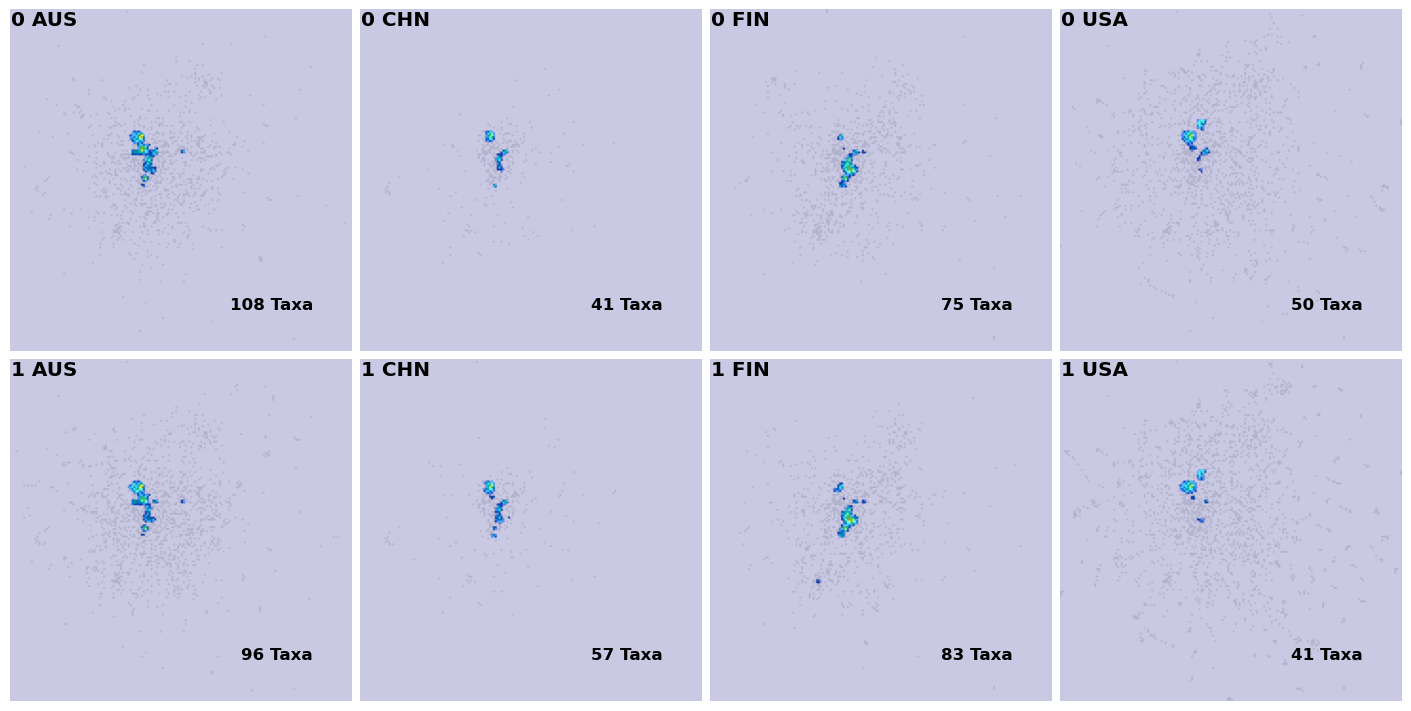

In [ ]:
_ = cam_image(X_full_img_tensor, y_img_tensor.detach().cpu().numpy(), class_mean, feat_mean, fs_threshold)
plt.savefig("Saliency_multi180.png")

In [ ]:
np.set_printoptions(suppress=True)
class_mean[1].shape

(180, 180)

In [ ]:
le_mapping
labels = ["HC AUS","HC CHN","HC FIN","HC USA","PD AUS","PD CHN","PD FIN","PD USA"]

In [ ]:
y_img_tensor

tensor([3, 3, 3,  ..., 4, 4, 4], dtype=torch.int32)

In [ ]:
#taxa = X.iloc[:, 2:].columns.to_numpy()
taxa = X_img.columns.to_numpy()
for cat, idx in feat_mean.items():
    #print(cat, idx)
    feature_names = taxa[idx]
    print(f"{idx.shape[0]:10} features selected for {le_mapping[cat]:10}: {', '.join(feature_names):5}...")

       108 features selected for 0 AUS     : Paenalcaligeneshominis, Gelriaglutamica, Sinosporangiumalbum, Bacillusfonticola, Enterococcusalcedinis, Chryseobacteriumdaeguense, RuminococcuslactarisATCC29176, Caminibacterhydrogeniphilus, BacteroidesrodentiumJCM16496, Paracholeplasmabrassicae0502, Streptococcusdentasini, Intestinimonasgabonensis, Prevotellaillustrans, Anaerotruncusmassiliensis, Treponemaputidum, Immundisolibactercernigliae, Glutamicibacterprotophormiae, Ruminococcuschampanellensis18P13JCM17042, Lactococcuslaudensis, Micrococcuslylae, Peptostreptococcusstomatis, Lactobacillusparagasseri, PorphyromonassomeraeDSM23386, Microbacteriumpopuli, Clostridiumfrigidicarnis, Caldalkalibacillusmannanilyticus, Leucobacteralbus, Brevundimonasbacteroides, Feifaniahominis, Sutterellamegalosphaeroides, Syntrophobotulusglycolicus, Enterococcusfaecalis, Pantoeaananatis, Noviherbaspirillumarenae, Brevibacillusagri, MethylorubrumpopuliBJ001, Campylobacterconcisus, Desulfosporosinusauripigmenti

In [ ]:
feat = pd.DataFrame()



for cat, idx in feat_mean.items():
    feature_names = taxa[idx]
    feat = pd.concat([feat, pd.DataFrame({'class':le_mapping[cat], 'taxa':feature_names})])
fdf = feat.assign(selected=1).pivot(index='class', columns='taxa', values="selected").fillna(0).astype(int)
# # Get the current index
# current_index = fdf.index.tolist()

# # Define the new order
# new_order = [0,4,1,5,2,6,3,7]

# # Create new index
# new_index = [current_index[i] for i in new_order]

# # Reindex the DataFrame
# fdf = fdf.reindex(new_index)
new_df = pd.DataFrame(
    np.matmul(fdf.values,fdf.T.values),
    index=fdf.index.values,
    columns=fdf.index.values
)
new_df

,0 AUS,0 CHN,0 FIN,0 USA,1 AUS,1 CHN,1 FIN,1 USA
0 AUS,108,20,47,32,68,28,51,24
0 CHN,20,41,28,15,22,22,25,15
0 FIN,47,28,75,33,48,40,46,25
0 USA,32,15,33,50,30,27,30,19
1 AUS,68,22,48,30,96,31,47,23
1 CHN,28,22,40,27,31,57,39,25
1 FIN,51,25,46,30,47,39,83,24
1 USA,24,15,25,19,23,25,24,41


In [ ]:
PD_hits= fdf.iloc[4:8]
PD_hits

taxa,Acidipropionibacteriumvirtanenii,Actinocorallialongicatena,Aeromonasenteropelogenes,Alicyclobacilluscurvatus,AlistipesfinegoldiiDSM17242,Allobacillussalarius,Anaerobiumacetethylicum,Anaerotruncusmassiliensis,Arachniapropionica,Azospirillumrugosum,...,Thermoclostridiumstercorariumsubspleptospartum,Thomasclaveliacocleata,Treponemaputidum,Vagococcushumatus,Vagococcusmartis,Virgibacillussiamensis,Walteraintestinalis,WeissellaoryzaeSG25,Xanthobacterflavus,Zoogloeaoryzae
class,,,,,,,,,,,,,,,,,,,,,
1 AUS,1,1,1,1,0,1,1,0,1,1,...,1,0,1,1,0,0,0,0,1,0
1 CHN,0,0,0,0,1,0,0,1,1,0,...,0,0,0,0,1,1,1,1,0,0
1 FIN,0,0,1,1,1,0,0,1,0,0,...,1,0,1,1,1,1,1,1,0,0
1 USA,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0


In [ ]:
current_df = transposed_df[list(common_cols)]
missing_cols = set(X_img.columns) - set(current_df.columns) 
for col in missing_cols:
    current_df[col] = 0

# reordercol for concat
pd_df= current_df[PD_hits.columns]
pd_sums = pd_df.sum(axis=1)
pd_sums[pd_sums>0]
tfdf = fdf.T
new_df2 = pd.DataFrame(
    np.matmul(tfdf.values,tfdf.T.values),
    index=tfdf.index.values,
    columns=tfdf.index.values
)
new_df2

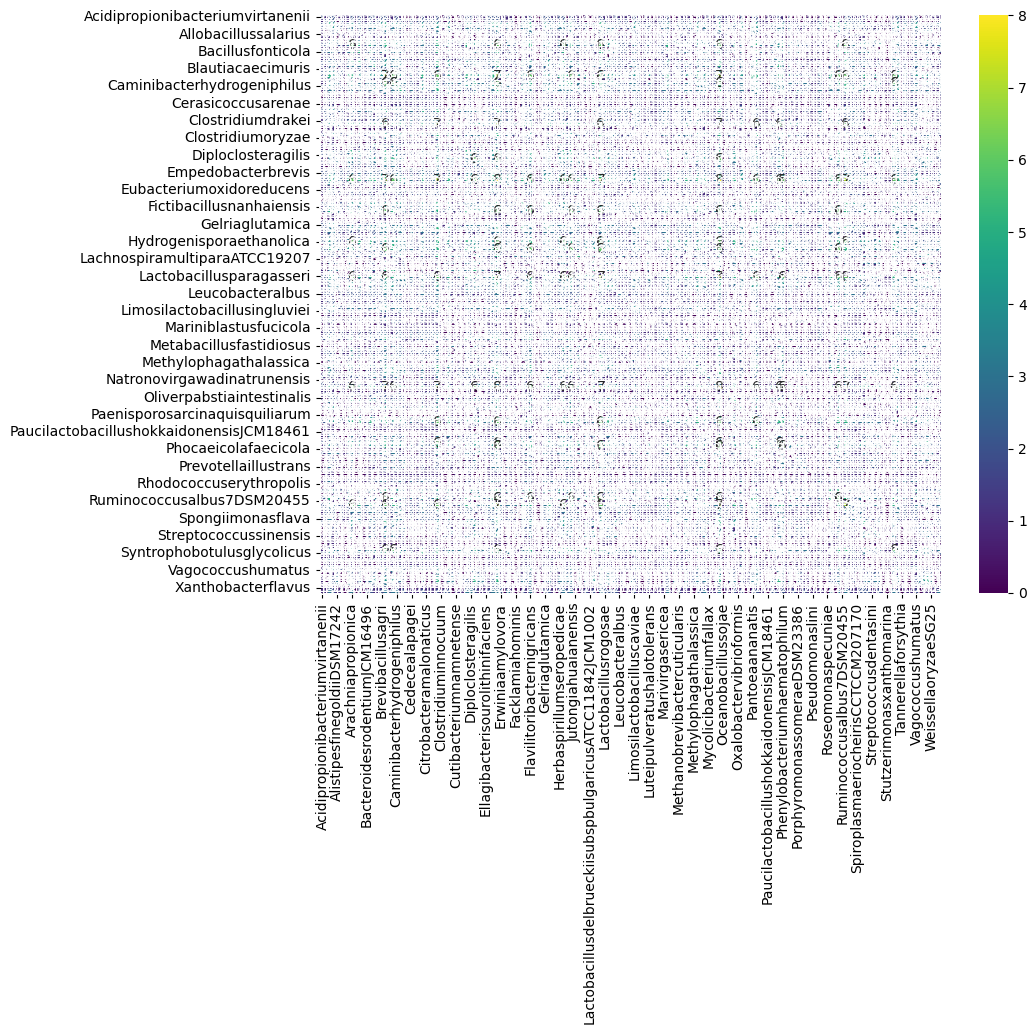

In [ ]:

import seaborn as sns
plt.figure(figsize=(10, 7.5))

sns.heatmap(new_df2, cmap="viridis", annot = True)

plt.show()